<a href="https://colab.research.google.com/github/EBUSYGIN/ML-3/blob/main/ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA

In [15]:

# Загрузка данных из .xlsx файлов
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test.xlsx')

# Переименование колонок
train_data = train_data.rename(columns={'dt': 'date', 'Цена на арматуру': 'price'})
test_data = test_data.rename(columns={'dt': 'date', 'Цена на арматуру': 'price'})

# Убедимся, что данные отсортированы по дате
train_data = train_data.sort_values(by='date')
test_data = test_data.sort_values(by='date')

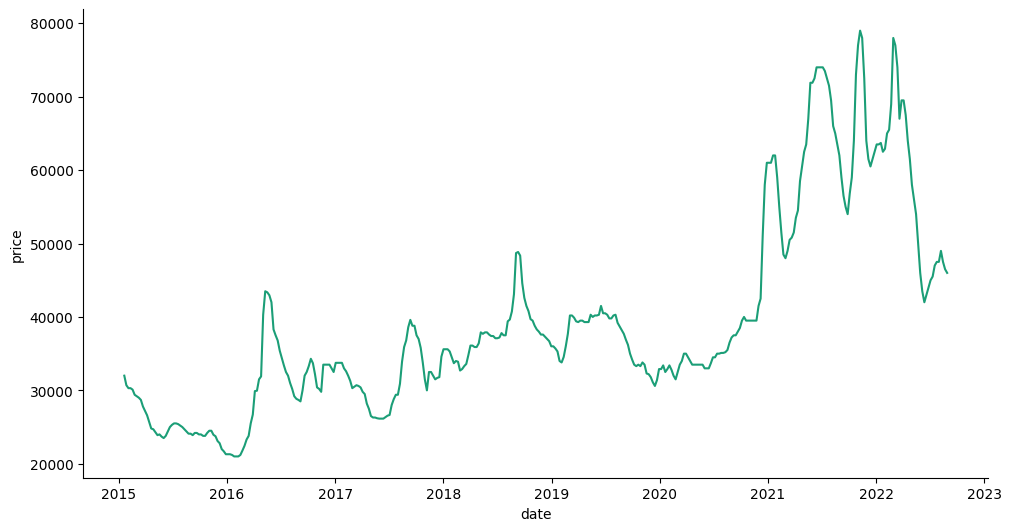

In [12]:
# @title date vs price

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_data.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('price')

In [16]:
# Проверка на стационарность (визуально или с помощью теста Дики-Фуллера)
# Если данные нестационарны, применяем дифференцирование
def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1] > 0.05  # Если p-value > 0.05, ряд нестационарен

is_non_stationary = check_stationarity(train_data['price'])
if is_non_stationary:
    print("Ряд нестационарен. Применяем дифференцирование.")
    train_data['price_diff'] = train_data['price'].diff().dropna()
else:
    print("Ряд стационарен.")

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Ряд нестационарен. Применяем дифференцирование.


In [19]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [20]:

# Подготовка данных для ARIMA
# Используем дифференцированный ряд, если он был создан
if 'price_diff' in train_data.columns:
    series = train_data['price_diff'].dropna()
else:
    series = train_data['price']

# Построение модели ARIMA
# Параметры (p, d, q):
# p - порядок авторегрессии (AR)
# d - порядок дифференцирования (I)
# q - порядок скользящего среднего (MA)
model = ARIMA(train, order=(5, 1, 2))  # Пример параметров (можно подобрать с помощью ACF/PACF)
model_fit = model.fit()
print(model_fit.summary())

# Прогнозирование на тестовой выборке
predictions = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f'MSE ARIMA: {mse}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                  319
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2671.424
Date:                Tue, 18 Mar 2025   AIC                           5358.849
Time:                        08:22:05   BIC                           5388.945
Sample:                             0   HQIC                          5370.869
                                - 319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0460      0.470      0.098      0.922      -0.876       0.967
ar.L2          0.3219      0.258      1.248      0.212      -0.184       0.827
ar.L3         -0.1032      0.069     -1.495      0.1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
# Прогнозирование на будущие периоды (например, на N недель)
future_steps = 4  # Прогноз на 4 недели
future_predictions = model_fit.forecast(steps=future_steps)
print("Прогноз на будущие периоды:", future_predictions)

Прогноз на будущие периоды: 319   -1808.662634
320    -961.517585
321    -317.085836
322     -96.317921
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: x and y must have same first dimension, but have shapes (81,) and (80,)

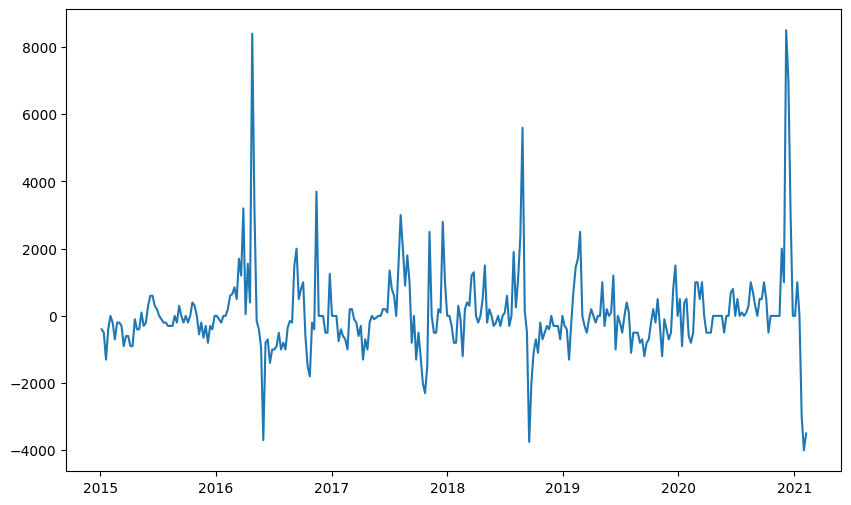

In [23]:
# Визуализация результатов
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_data['date'][:train_size], train, label='Обучающие данные')
plt.plot(train_data['date'][train_size:], test, label='Тестовые данные')
plt.plot(train_data['date'][train_size:], predictions, label='Прогноз ARIMA')
plt.legend()
plt.title('Прогнозирование с использованием ARIMA')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.show()